In [20]:
from PIL import Image
import math
import numpy as np
import matplotlib.pyplot as plt 

In [21]:
# XYZ Reference values from easyRGB.com
# Illuminant = D65 and Observer = 2 for sRGB
referenceX = 95.047
referenceY = 100.000
referenceZ = 108.883

In [22]:
# General functions

# Opens image as numpy array
def openImg(filename):
    im = Image.open(filename)
    mode = im.mode
    im = np.array(im, dtype=np.uint8)
    if (mode == "RGBA"):
        im = im[:, :, :3]
    return im

# Adapted from easyRGB.com
# Takes RGB values -> XYZ -> Lab
def rgb2lab(rgb):
    # sRGB to XYZ
    R = rgb[0] / 255
    G = rgb[1] / 255
    B = rgb[2] / 255
    
    if R > 0.04045:
        R = math.pow(((R + 0.055) / 1.055), 2.4)
    else:
        R /= 12.92
    if G > 0.04045:
        G = math.pow(((G + 0.055) / 1.055), 2.4)
    else:
        G /= 12.92
    if B > 0.04045:
        B = math.pow(((B + 0.055) / 1.055), 2.4)
    else:
        B /= 12.92
        
    R *= 100
    G *= 100
    B *= 100
    
    X = (R * 0.4124) + (G * 0.3576) + (B * 0.1805)
    Y = (R * 0.2126) + (G * 0.7152) + (B * 0.0722)
    Z = (R * 0.0193) + (G * 0.1192) + (B * 0.9505)
    
    # XYZ to Lab
    X /= referenceX
    Y /= referenceY
    Z /= referenceZ
    
    if X > 0.008856:
        X = math.pow(X, 1/3)
    else:
        X = (7.787 * X) + (16 / 116)
    if Y > 0.008856:
        Y = math.pow(Y, 1/3)
    else:
        Y = (7.787 * Y) + (16 / 116)
    if Z > 0.008856:
        Z = math.pow(Z, 1/3)
    else:
        Z = (7.787 * Z) + (16 / 116)
        
    L = (116 * Y) - 16
    a = 500 * (X - Y)
    b = 200 * (Y - Z)
    
    return [L, a, b]

# Adapted from easyRGB.com
# Takes Lab values -> XYZ -> RGB
def lab2rgb(Lab, bound = 1):
    # Lab to XYZ
    Y = (Lab[0] + 16) / 116
    X = Lab[1] / 500 + Y
    Z = Y - Lab[2] / 200
    
    if math.pow(Y, 3) > 0.008856:
        Y = math.pow(Y, 3)
    else:
        Y = (Y - 16 / 116) / 7.787
    if math.pow(X, 3) > 0.008856:
        X = math.pow(X, 3)
    else:
        X = (X - 16 / 116) / 7.787
    if math.pow(Z, 3) > 0.008856:
        Z = math.pow(Z, 3)
    else:
        Z = (Z - 16 / 116) / 7.787
        
    X *= referenceX
    Y *= referenceY
    Z *= referenceZ
    
    # XYZ to sRGB
    X /= 100
    Y /= 100
    Z /= 100
    
    R = X *  3.2406 + Y * -1.5372 + Z * -0.4986
    G = X * -0.9689 + Y *  1.8758 + Z *  0.0415
    B = X *  0.0557 + Y * -0.2040 + Z *  1.0570
    
    if R > 0.0031308:
        R = 1.055 * math.pow(R, 1/2.4) - 0.055
    else:
        R *= 12.92
    if G > 0.0031308:
        G = 1.055 * math.pow(G, 1/2.4) - 0.055
    else:
        G *= 12.92
    if B > 0.0031308:
        B = 1.055 * math.pow(B, 1/2.4) - 0.055
    else:
        B *= 12.92
        
    R *= 255
    G *= 255
    B *= 255
    
    if bound:
        R = round(min(max(R, 0), 255))
        G = round(min(max(G, 0), 255))
        B = round(min(max(B, 0), 255))
    
    return [R, G, B]

# Calculate the distance between two colors in Lab space
# Inputs:
#     Lab1: Lab value of first color
#     Lab2: Lab value of second color  
def getLabDistance(Lab1, Lab2):
    L1 = Lab1[0]
    a1 = Lab1[1]
    b1 = Lab1[2]
    L2 = Lab2[0]
    a2 = Lab2[1]
    b2 = Lab2[2]
    L = L1-L2
    a = a1-a2
    b = b1-b2
    return math.sqrt((L*L)+(a*a)+(b*b))

In [84]:
class Palette:
    def __init__(self, k = 5):
        self.k = k
        
        self.orig = np.zeros((self.k,3))
        self.edit = np.zeros((self.k,3))
        self.curr = np.zeros((self.k,3))
        
        self.sigma = 0
        
    def setSigma(self):
        count = 0
        for i in range(self.k):
            for j in range(i, self.k):
                self.sigma += getLabDistance(self.orig[i],self.orig[j])
                count += 1
        self.sigma /= count
        
    def setOrigPalette(self, palette):
        for i in range(self.k):
            self.orig[i] = palette[i]
            self.edit[i] = palette[i]
            self.curr[i] = palette[i]
        self.setSigma()
            
    # Updates the palette when a color is modified, maintaining monotonicity in luminance
    # Inputs:
    #     current_palette: palette to be updated, also contains info about the last user-edited value
    #     p: index of the palette color being modified
    #     RGB: color to be set
    def setColorPalette(self, p, RGB):
        if p >= self.k:
            raise IndexError('index out of range')
        Lab = rgb2lab(RGB)
        self.curr[p] = Lab
        self.edit[p] = Lab
        for i in range(p+1, self.k):
            self.curr[i][0] = min(self.curr[i][0], self.curr[i-1][0])
        for i in range(p-1, -1, -1):
            self.curr[i][0] = max(self.curr[i][0], self.curr[i+1][0])

In [5]:
# Color Palette Selection
def binLab(image):
    bins = np.zeros((16*16*16,4))
    for c in range(len(image)):
        for r in range(len(image[0])):
            Lab = rgb2lab(image[c][r])
            Lab = np.array([Lab[0], Lab[1], Lab[2], 1])
            binL = int(Lab[0]//16)
            bina = int(Lab[1]//16)
            binb = int(Lab[2]//16)
            bindex = binL * 16 * 16 + bina * 16 + binb
            bins[bindex] += [Lab[0], Lab[1], Lab[2], 1]
    for i in range(len(bins)):
         if bins[i][3] != 0:
            Lab = bins[i][:3]/bins[i][3]
            Lab = [Lab[0], Lab[1], Lab[2], bins[i][3]]
            bins[i] = Lab
    bins = bins[np.all(bins != 0, axis=1)]
    return bins
    
def kmeans(k, bins):
    # Choosing the initial palette
    palette = np.zeros((k+1,4))
    init_bins = bins.copy()
    for p in range(k):
        max_p = 0
        for bindex in range(len(init_bins)):
            if init_bins[bindex][3] > init_bins[max_p][3]:
                max_p = bindex
        palette[p] = init_bins[max_p]
        
        p_lab = palette[p][:3]
        for bindex in range(len(init_bins)):
            c_lab = init_bins[bindex][:3]
            lab_dist = getLabDistance(p_lab,c_lab)
            sigma = 80
            init_bins[bindex][3] *= (1 - math.exp(-math.pow(lab_dist,2)/math.pow(sigma,2)))
            
    # Proceed with the rest of the k-means algorithm
    stable = False
    while not stable:
        new_palette = np.zeros((k+1,4))
        for bindex in range(len(bins)):
            min_dist = float('inf')
            min_p = -1
            for p in range(k+1):
                p_lab = palette[p]
                c_lab = bins[bindex][:3]
                curr_dist = getLabDistance(p_lab,c_lab)
                if min_dist > curr_dist:
                    min_dist = curr_dist
                    min_p = p
            if min_p != k:
                total_bin = bins[bindex][:3] * bins[bindex][3]
                total_bin = [total_bin[0], total_bin[1], total_bin[2], bins[bindex][3]]
                new_palette[min_p] += total_bin
            
        # Find new average color for each palette entry
        for p in range(k+1):
            if new_palette[p][3] != 0:
                Lab = new_palette[p][:3]/new_palette[p][3]
                new_palette[p] = [Lab[0], Lab[1], Lab[2], new_palette[p][3]]
            matching = palette[p][:3] == new_palette[p][:3]
            matching = matching.all()
            if p == 0:
                stable = matching
            stable = stable and matching
        palette = new_palette.copy()
    
    # Sort the palette by the L value
    tmp_palette = palette.copy()[:k]
    len_tmp = len(tmp_palette)
    for p in range(k):
        max_L = float('-inf')
        max_i = k+1
        for i in range(len_tmp):
            if max_L < tmp_palette[i][0]:
                max_L = tmp_palette[i][0]
                max_i = i
        palette[p] = tmp_palette[max_i]
        tmp_palette[max_i] = tmp_palette[len_tmp-1]
        len_tmp -= 1
    return palette[:, :3]

In [6]:
# Color Transfer Functions
def transferL(Lab, palette):
    Lab_black = rgb2lab([0,0,0])
    Lab_white = rgb2lab([255,255,255])
    closest_dist = np.zeros(2)
    closest_p = np.zeros(2, dtype=int)
    for i in range(palette.k):
        lab_dist = getLabDistance(Lab, palette.curr[i])
        if (Lab == palette.curr[i]).all():
            return Lab
        if lab_dist < closest_dist[0]:
            closest_dist[1] = closest_dist[0]
            closest_p[1] = closest_p[0]
            closest_dist[0] = lab_dist
            closest_p[0] = i
        elif lab_dist < closest_dist[1]:
            closest_dist[1] = lab_dist
            closest_p[1] = i
    curr_L1 = palette.curr[closest_p[0]][0]
    curr_L2 = palette.curr[closest_p[1]][0]
    orig_L1 = palette.orig[closest_p[0]][0]
    orig_L2 = palette.orig[closest_p[1]][0]
    if orig_L1 == orig_L2:
        Lab[0] = curr_L1
    else:
        Lab[0] = ((Lab[0] - orig_L1) / (orig_L2 - orig_L1)) * (curr_L2 - curr_L1) + curr_L1
    return Lab

# outofgamut
# gamutbounds
# intersections

def isInGamut(Lab):
    RGB = lab2rgb(Lab, 0)
    for i in range(len(RGB)):
        if RGB[i] < 0 or RGB[i] > 255:
            return False
    return True

def boundaryIntersection(Lab1, Lab2, min_t = 0, max_t = 300):
    position = Lab1
    direction = Lab2 - Lab1
    midpoint = 0.5 * (max_t - min_t)
    while midpoint > 0.1:
        guess = position + midpoint * direction
        if isInGamut(guess):
            max_t = midpoint
        else:
            min_t = midpoint
        midpoint = 0.5 * (max_t - min_t)
    return guess

def phi(r, sigma):
    return math.exp(-math.pow(r,2) / (2 * math.pow(sigma,2)))

def transferab(Lab, palette):
    x = Lab
    
    f = np.zeros(palette.k)
    phi = np.zeros(palette.k)
    Lambda = np.zeros((palette.k,palette.k))
    
    for i in range(palette.k):
        C = palette.orig[i]
        C_prime = palette.curr[i]
        C_b = boundaryIntersection(C, C_prime) # where C -> C' intersect RGB bounds
        x_o = x + C_prime - C
        if (isInGamut(x)):
            x_b = boundaryIntersection(x, x_o) # where parallel ray where x intersects bounds
        else:
            x_b = boundaryIntersection(C_prime, x_o) # ray from C' -> xo intersects bounds
        x_prime = min(1, abs(x_b - x)/abs(C_b - C)) * abs(C_prime - C) + x
        f[i] = x_prime
        phi[j] = phi(abs(x - palette[j]), sigma)
        
    for i in range(palette.k):
        for j in range(palette.k):
            if i == j:
                Lambda[i][j] = 1
    return 0

SyntaxError: invalid syntax (<ipython-input-6-65ec0b05b4c6>, line 65)

In [86]:
palette = Palette(5)
im = openImg('sample.png')
bins = binLab(im)
palette.setOrigPalette(kmeans(palette.k, bins))

current_palette = np.zeros((3,5,3))
# 0: current, 1: last user-edited value, 2: original
current_palette[0][0] = [162, 160, 170]
current_palette[0][1] = [190, 151, 120]
current_palette[0][2] = [104, 127, 165]
current_palette[0][3] = [107, 91, 79]
current_palette[0][4] = [65, 57, 38]
current_palette[1][0] = [162, 160, 170]
current_palette[1][1] = [190, 151, 120]
current_palette[1][2] = [104, 127, 165]
current_palette[1][3] = [107, 91, 79]
current_palette[1][4] = [65, 57, 38]
current_palette[2][0] = [162, 160, 170]
current_palette[2][1] = [190, 151, 120]
current_palette[2][2] = [104, 127, 165]
current_palette[2][3] = [107, 91, 79]
current_palette[2][4] = [65, 57, 38]
for i in range(len(current_palette)):
    for j in range(len(current_palette[i])):
        current_palette[i][j] = rgb2lab(current_palette[i][j])

current_palette = updateColorPalette(current_palette, 3, [0,0,0])
palette_color = rgb2lab([190, 151, 120])
random_color = rgb2lab([56, 28, 90])
print(palette_color,random_color)
palette_color = transferL(palette_color, current_palette)
print(palette_color)
palette_color = lab2rgb(palette_color)
random_color = lab2rgb(transferL(random_color, current_palette))
print(palette_color,random_color)
canvas = np.zeros((2,1,3), dtype=np.uint8)
canvas[0][0] = palette_color
canvas[1][0] = random_color
plt.imshow(canvas)

def testColorConversion1():
    im = np.zeros(shape = (255, 255, 3), dtype=np.uint8)
    for y in range(len(im)):
        for x in range(len(im[0])):
            im[y][x] = [x, y, 200]

    im_lab = np.zeros(shape = (255, 255, 3), dtype=int)
    for c in range(len(im_lab)):
        for r in range(len(im_lab[0])):
            im_lab[c][r] = rgb2lab(im[c][r])

    im_rgb = np.zeros(shape = (255, 255, 3), dtype=np.uint8)
    for c in range(len(im_rgb)):
        for r in range(len(im_rgb[0])):
            im_rgb[c][r] = lab2rgb(im_lab[c][r])

    imPIL = Image.fromarray(im.astype('uint8'), 'RGB')
    im_rgbPIL = Image.fromarray(im_rgb.astype('uint8'), 'RGB')
    display(imPIL, im_rgbPIL)
    
testColorConversion1()

def testColorConversion2():
    im = openImg('sample.png')
    im_lab = np.zeros(im.shape, dtype=int)
    for c in range(len(im_lab)):
        for r in range(len(im_lab[0])):
            im_lab[c][r] = rgb2lab(im[c][r])

    im_rgb = np.zeros(im.shape, dtype=np.uint8)
    for c in range(len(im_rgb)):
        for r in range(len(im_rgb[0])):
            im_rgb[c][r] = lab2rgb(im_lab[c][r])

    imPIL = Image.fromarray(im.astype('uint8'), 'RGB')
    im_labPIL = Image.fromarray(im_lab.astype('uint8'), 'LAB')
    im_rgbPIL = Image.fromarray(im_rgb.astype('uint8'), 'RGB')
    L,a,b = im_labPIL.split()
    display(imPIL, L, a, b, im_rgbPIL)

testColorConversion2()

[[ 66.98818373   2.87712323  -4.36933016]
 [ 60.93961207   9.35261236  20.823478  ]
 [ 50.77474696   0.9370391  -23.84231713]
 [ 30.24885365   2.01222598  12.56007309]
 [ 27.58005626   1.32839305  -7.59057988]
 [  0.           0.           0.        ]]
[[165 162 171]
 [176 140 111]
 [ 96 122 161]
 [ 81  70  52]
 [ 61  65  77]]


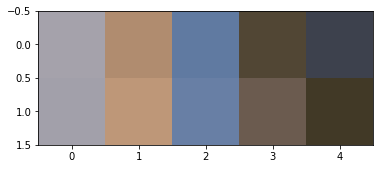

In [41]:
def testPaletteGeneration():
    im = openImg('sample.png')
    bins = binLab(im)
    palette = kmeans(5, bins)
    print(palette)
    canvas = np.zeros((2,5,3), dtype=np.uint8)
    for i in range(5):
        canvas[0][i] = lab2rgb(palette[i][:3])
    print(canvas[0])
    # Palette colors from the demo
    canvas[1][0] = [162, 160, 170]
    canvas[1][1] = [190, 151, 120]
    canvas[1][2] = [104, 127, 165]
    canvas[1][3] = [107, 91, 79]
    canvas[1][4] = [65, 57, 38]
    plt.imshow(canvas)
    
testPaletteGeneration()

def testMonotonicL():
    original_palette = np.zeros((5,3))
    original_palette[0] = [162, 160, 170]
    original_palette[1] = [190, 151, 120]
    original_palette[2] = [104, 127, 165]
    original_palette[3] = [107, 91, 79]
    original_palette[4] = [65, 57, 38]
    current_palette = np.zeros((2,5,3))
    for i in range(len(original_palette)):
        current_palette[0][i] = rgb2lab(original_palette[i])
        current_palette[1][i] = rgb2lab(original_palette[i])
    current_palette = updateColorPalette(current_palette, 2, [242, 242, 243])
    canvas = np.zeros((2,5,3), dtype=np.uint8)
    for i in range(len(original_palette)):
        canvas[0][i] = lab2rgb(current_palette[0][i])
        canvas[1][i] = lab2rgb(current_palette[1][i])
    print(canvas[0])
    plt.imshow(canvas)
    
testMonotonicL()